In [1]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
import pickle
from sklearn.preprocessing import StandardScaler
from time import time
import cv2

In [3]:
dataset = []
image = nib.load('./ADNI_011_S_0010_PET_30_min_3D_FDG_4i_16s__br_raw_20051114113046731_1_S10060_I8664.nii')
dataset.append(np.array(image.get_fdata())[:,:,:,0]/np.array(image.get_fdata())[:,:,:,0].max())
dataset = np.array(dataset)

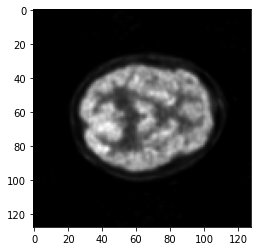

In [4]:
plt.imshow(dataset[0][:,:,32],cmap='gray')
plt.show()

In [5]:
class SuperVoxel():
    '''Class to represent a supervoxel'''
    def __init__(self,intensity,x,y,z):
        self.i = intensity
        self.x = x
        self.y = y
        self.z = z
        self.coord = np.array((x,y,z))
        self.voxels = {}
        
    def update(self,intensity,x,y,z):
        self.i = intensity
        self.x = x
        self.y = y
        self.z = z
        self.coord = np.array((x,y,z))

    def describe(self):
        print("Coordinates: ",self.coord," Intensity: ",self.i, " Voxel Count: ",len(self.voxels))
      
        

In [6]:
def imageConvert(img,clusters):
    image = np.asarray(img).copy()
    for c in tqdm(clusters):
        for x,y,z in c.voxels:
            image[x,y,z]=c.i
    return image

In [7]:
#Importing file
pkl = open('clusters.pkl','rb')

clusters = pickle.load(pkl)

pkl.close()

In [8]:
converted = imageConvert(dataset[0],clusters)

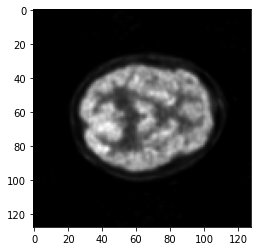

In [9]:
plt.imshow(dataset[0][:,:,32],cmap='gray')
plt.show()

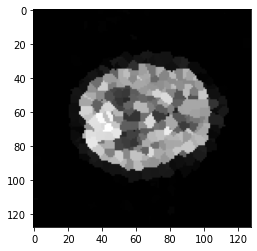

In [10]:
plt.imshow(converted[:,:,32],cmap='gray')
plt.show()

In [11]:
## Converting clusters to a datset
c_dataset = []

for c in clusters:
    c_dataset.append([c.i])
    
c_dataset = np.array(c_dataset)

In [12]:
#Scaling 
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(c_dataset)

In [13]:
scaled_dataset[:10,:]

array([[-0.41088264],
       [-0.41088264],
       [-0.41088264],
       [-0.41088264],
       [-0.41088264],
       [-0.41088264],
       [-0.41088264],
       [-0.41088264],
       [-0.41088264],
       [-0.41088264]])

In [14]:
level = 36

## Attempt with DBScan

In [15]:
from sklearn.cluster import DBSCAN

In [73]:
start = time()
dbscan = DBSCAN(eps=0.007,min_samples=15)
lables = dbscan.fit_predict(scaled_dataset)
stop = time()
print("Time Taken: %1.5f s"%(stop-start))

Time Taken: 0.31570 s


In [74]:
len(set(lables))

6

In [75]:
#Creating Segments
segments = []
shape = dataset[0].shape
for i in set(lables):
    blank = np.zeros(shape)
    for c in np.array(clusters)[lables==i]:
        #blank[c.coord]=1.0
        for v in c.voxels.keys():
            blank[v] = 1.0
            
    
    segments.append(blank)

segments = np.array(segments)

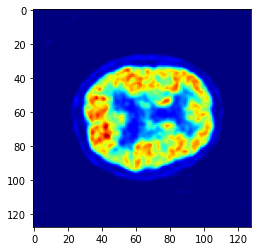

In [76]:
plt.imshow(dataset[0][:,:,level],cmap='jet')
plt.show()

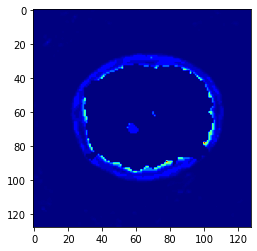

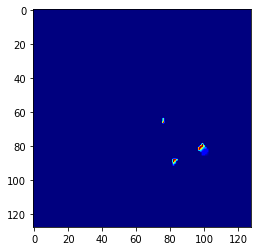

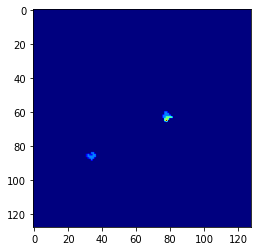

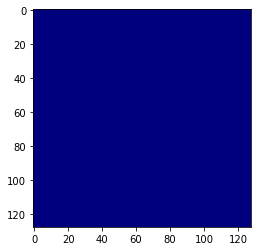

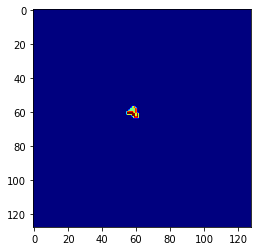

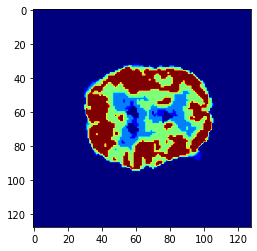

In [77]:
for seg in segments:
    plt.imshow(cv2.bitwise_and(seg[:,:,level],dataset[0][:,:,level]),cmap='jet')
    plt.show()

In [135]:
for i in set(lables):

    s = 0
    cnt = 0
    for c in np.array(clusters)[lables==i]:
        cnt += len(c.voxels.keys())
        for v in c.voxels.keys():
            s += dataset[0][v]
    print("For cluster ",i," mean = ",s/cnt)
            

For cluster  0  mean =  0.021576092076507684
For cluster  1  mean =  0.4645604343667271
For cluster  2  mean =  0.4624677006298367
For cluster  3  mean =  0.6321837483578332
For cluster  -1  mean =  0.42913837249465075


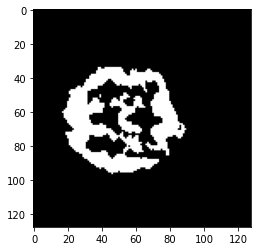

In [675]:
plt.imshow(np.logical_xor(segments[0],np.ones(shape))[:,:,level],cmap='gray')

In [676]:
dbsc = np.logical_xor(segments[0],np.ones(shape))

## Trying Spectral Clustering

In [677]:
n_clusters = 2

In [714]:
start = time()
sc = SpectralClustering(n_clusters=n_clusters)
lables = sc.fit_predict(scaled_dataset)
stop = time()
print("Time Taken: %1.5f s"%(stop-start))

Time Taken: 37.05423 s


In [679]:
#Creating Segments
segments = []
shape = dataset[0].shape
for i in range(n_clusters):
    blank = np.zeros(shape)
    for c in np.array(clusters)[lables==i]:
        #blank[c.coord]=1.0
        for v in c.voxels.keys():
            blank[v] = 1.0
            
    
    segments.append(blank)

segments = np.array(segments)

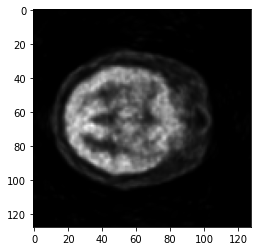

In [680]:
plt.imshow(dataset[0][:,:,level],cmap='gray')
plt.show()

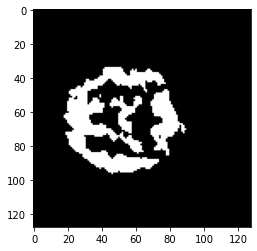

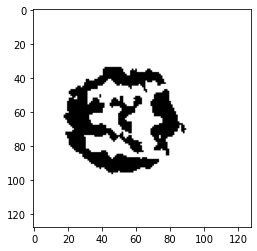

In [682]:
for seg in segments:
    plt.imshow(seg[:,:,level],cmap='gray')
    plt.show()

In [684]:
for i in set(lables):

    s = 0
    cnt = 0
    for c in np.array(clusters)[lables==i]:
        cnt += len(c.voxels.keys())
        for v in c.voxels.keys():
            s += dataset[0][v]
    print("For cluster ",i," mean = ",s/cnt)
            

For cluster  0  mean =  0.36809419705425844
For cluster  1  mean =  0.030572907461574345


In [689]:
spect = segments[0]

## Final Segments

In [715]:
def plot_segment(level):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(15,15))
    ax1.imshow(k_means[:,:,level],cmap='gray')
    ax2.imshow(dbsc[:,:,level],cmap='gray')
    ax3.imshow(spect[:,:,level],cmap='gray')
    ax4.imshow(dataset[0][:,:,level],cmap='gray')

    ax1.title.set_text('KMeans')
    ax2.title.set_text('DBScan')
    ax3.title.set_text('Spectral')
    ax4.title.set_text('Original')
    
    plt.show()

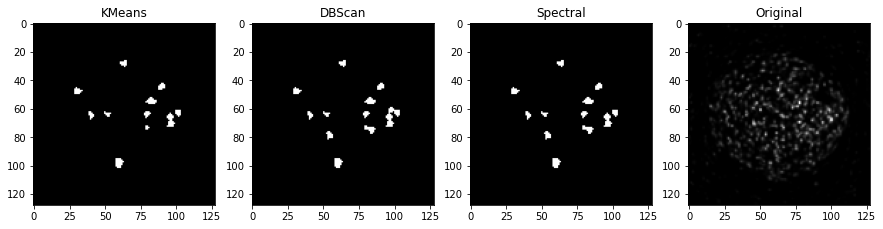

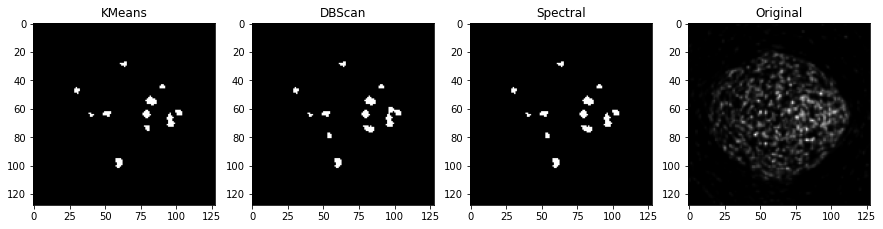

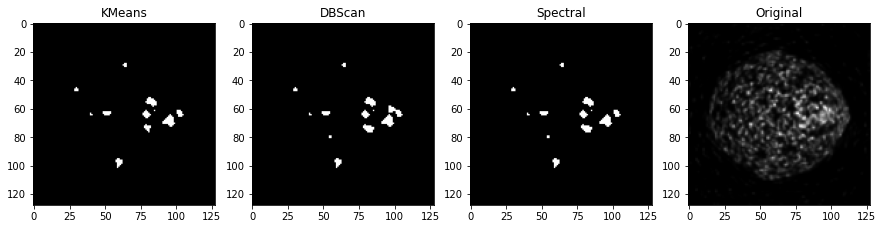

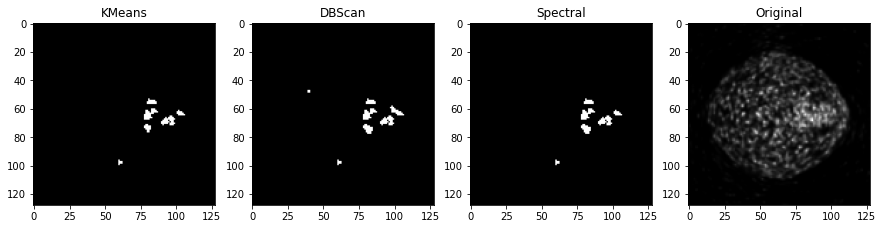

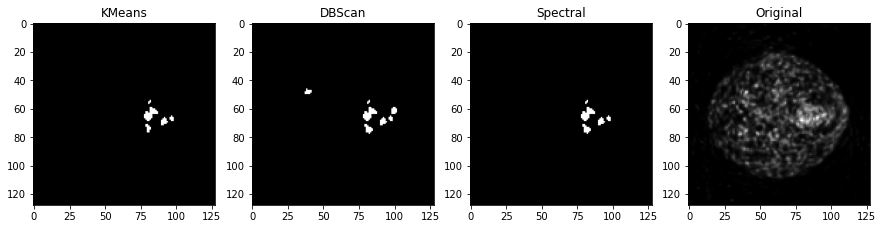

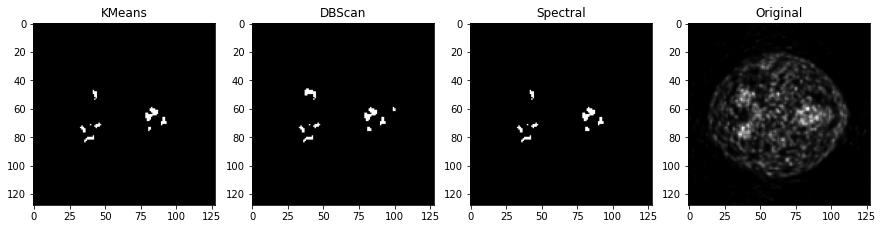

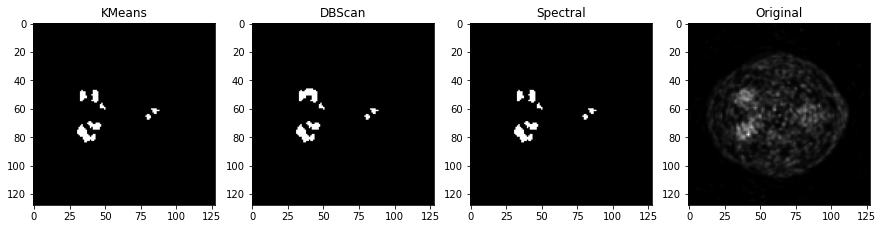

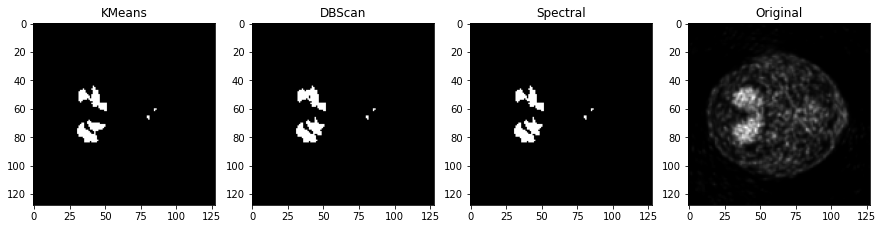

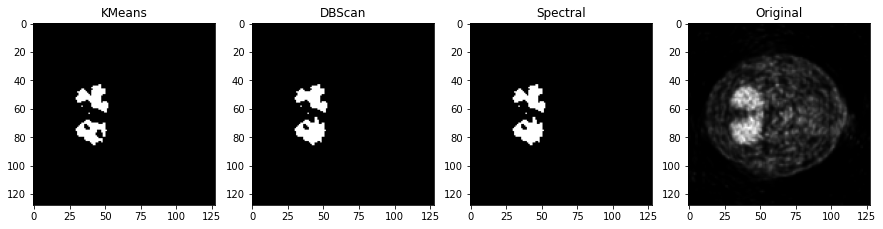

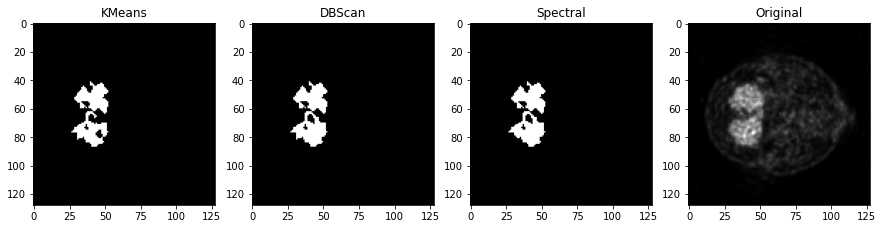

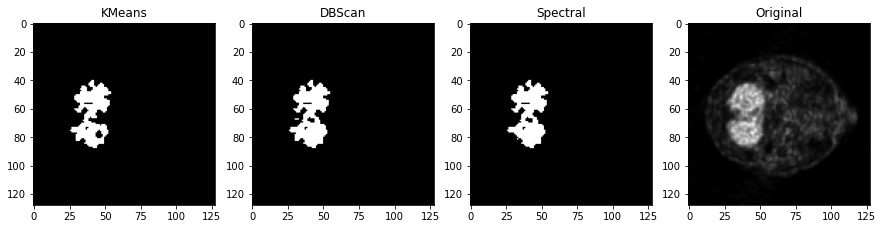

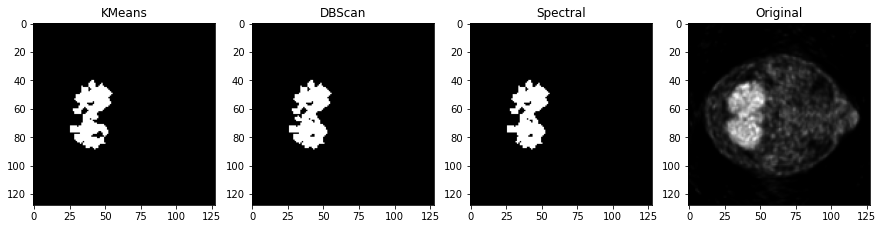

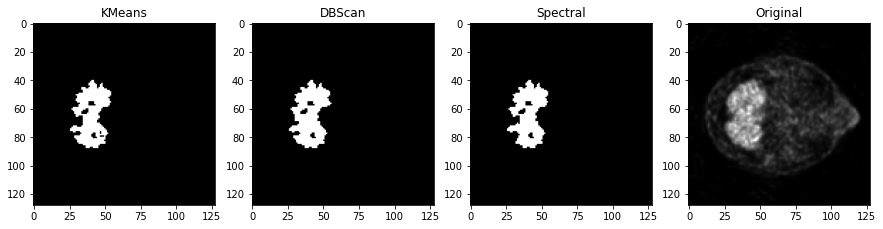

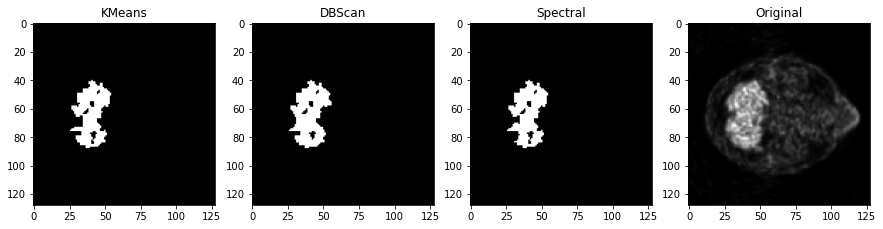

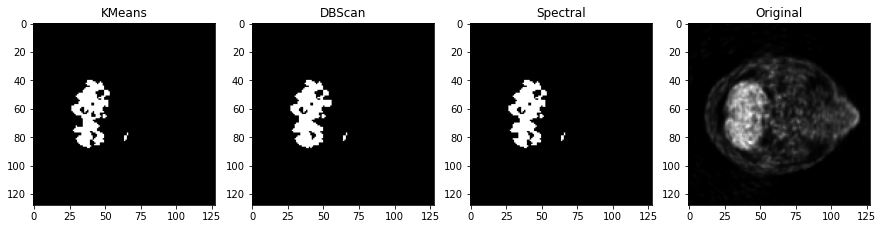

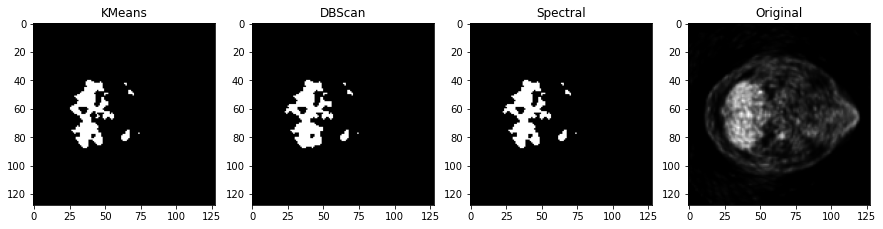

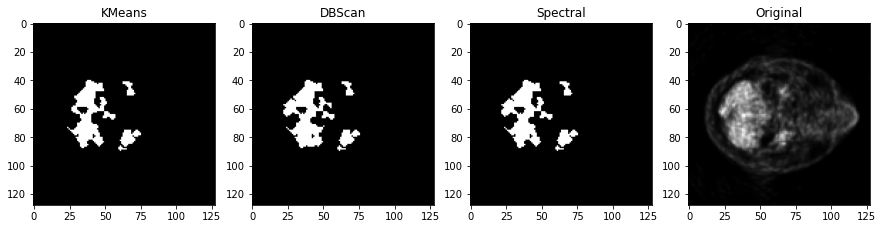

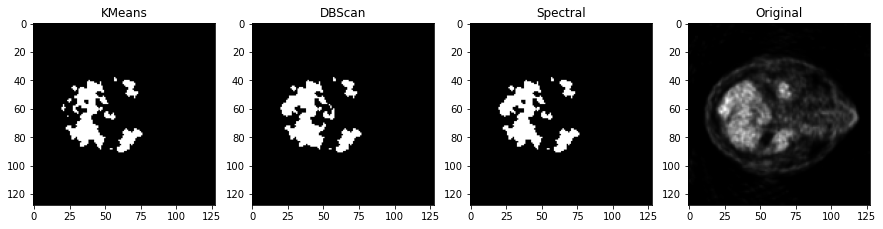

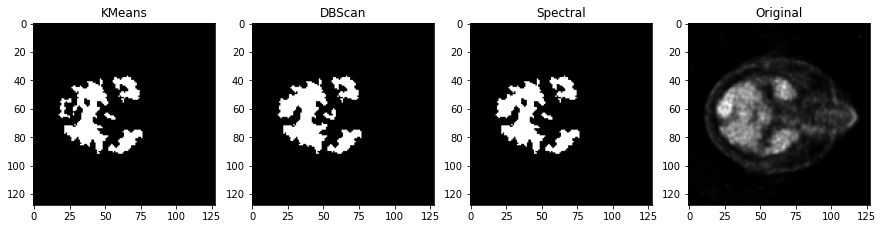

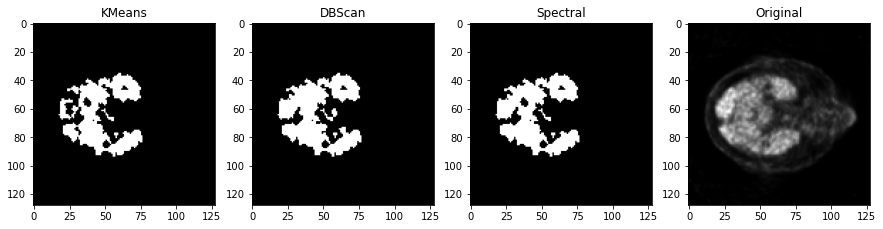

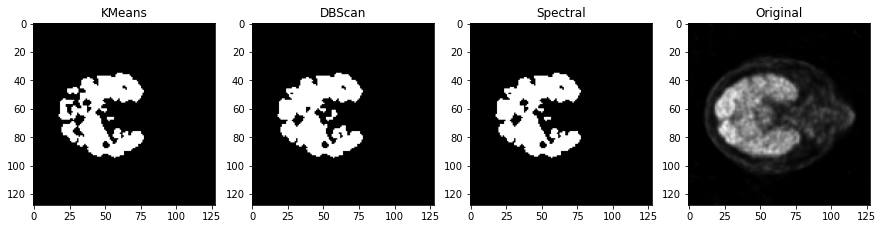

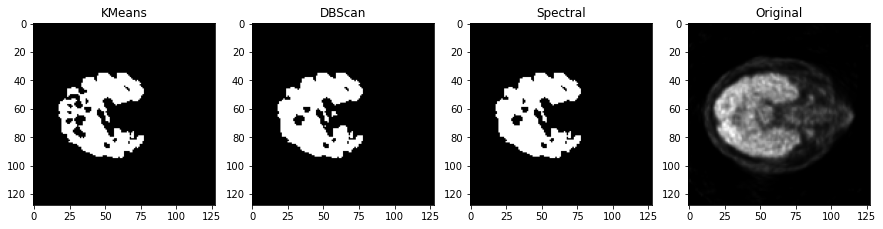

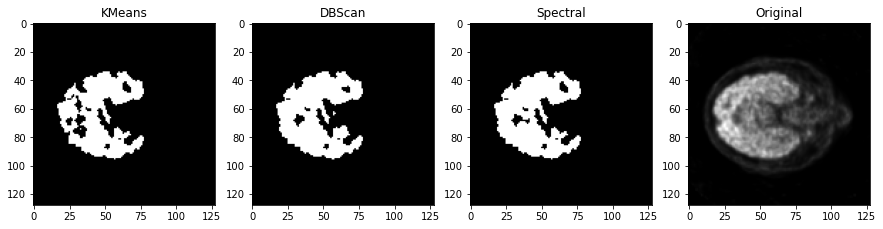

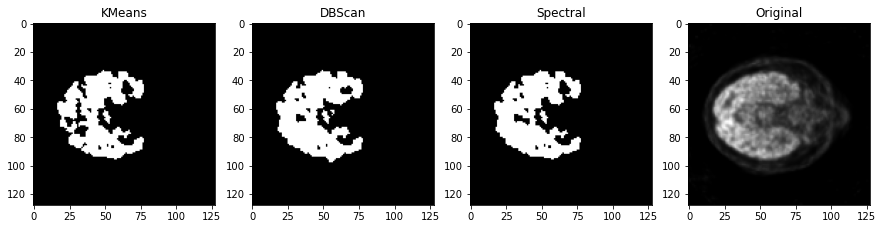

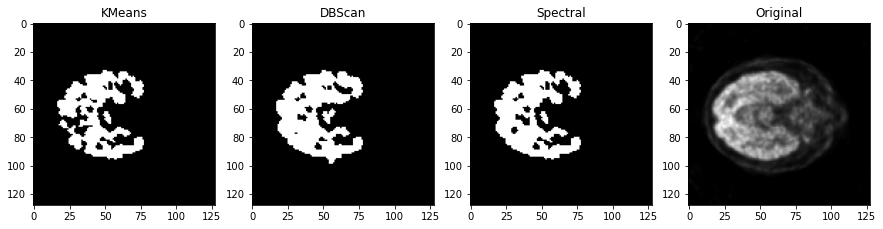

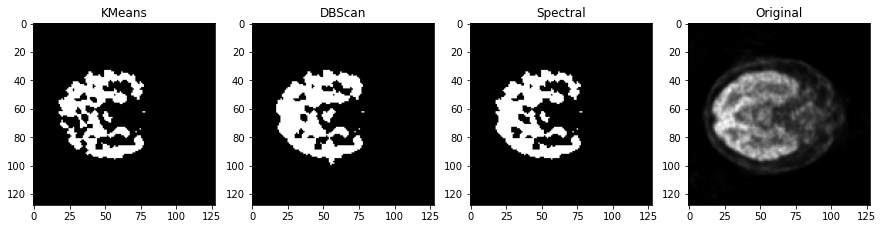

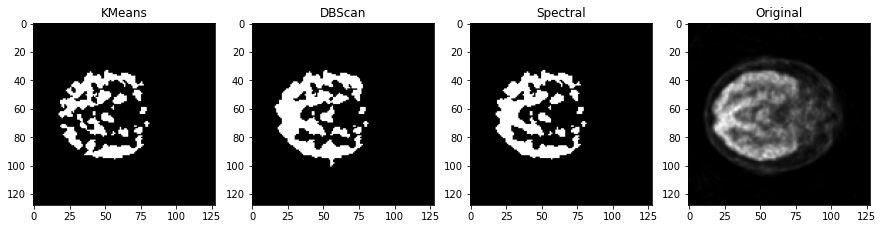

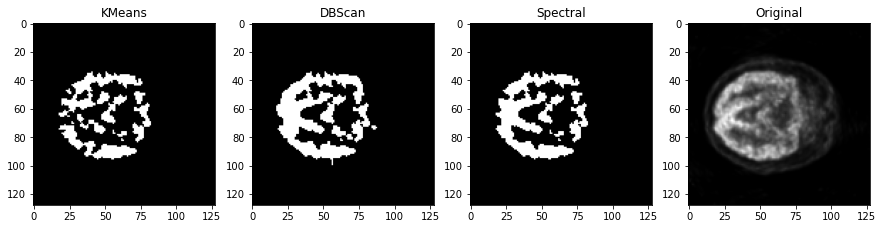

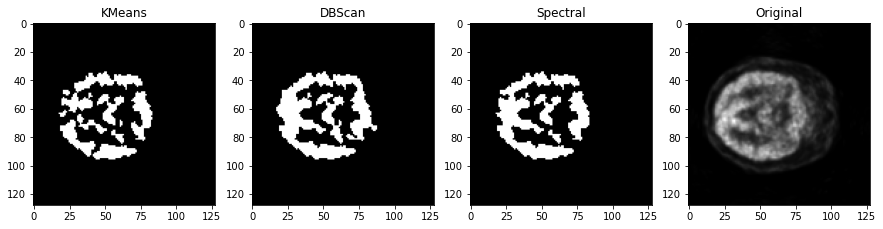

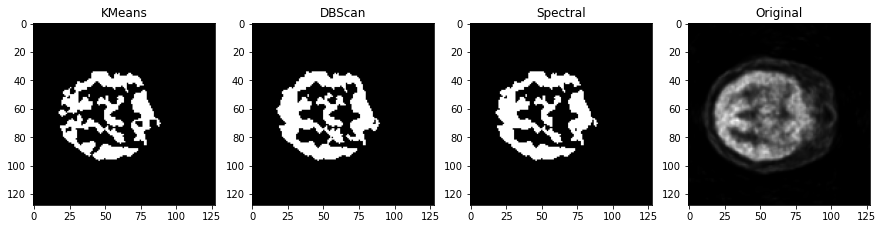

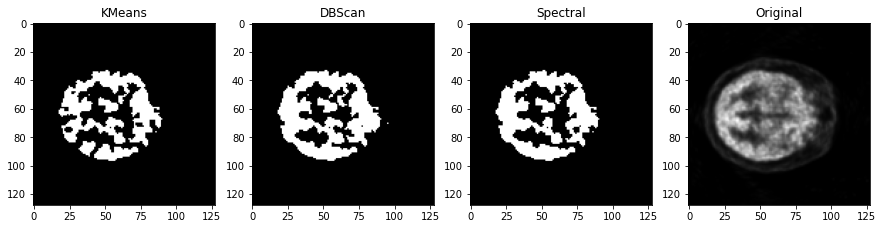

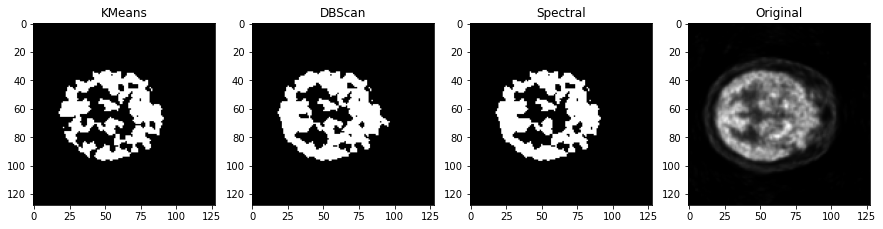

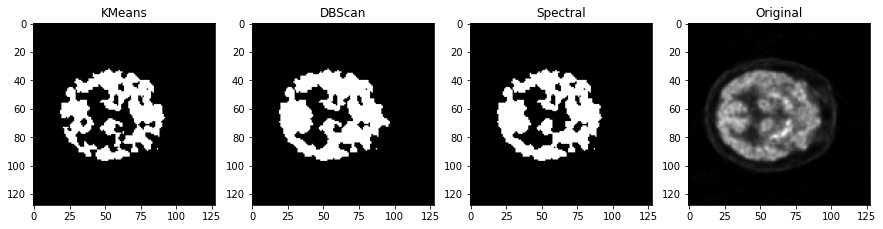

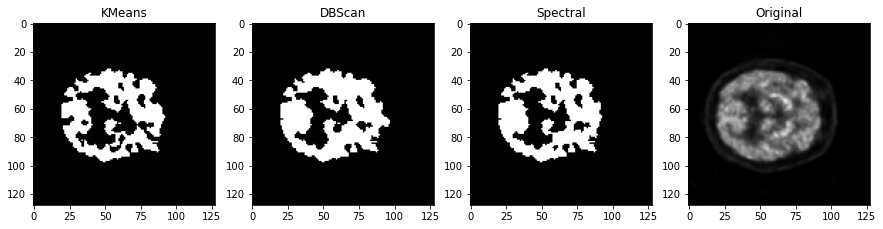

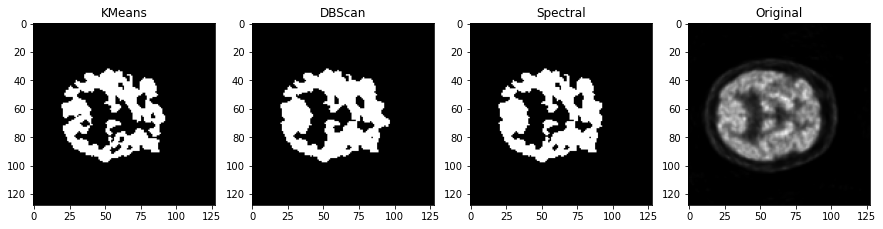

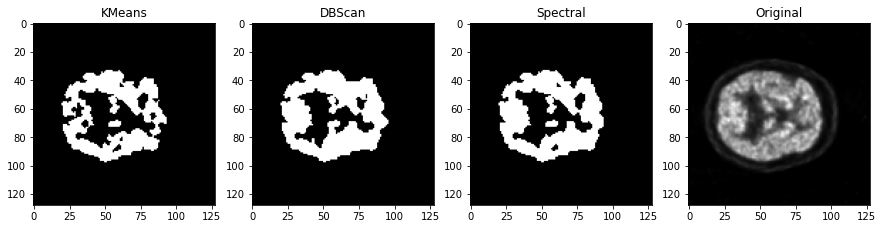

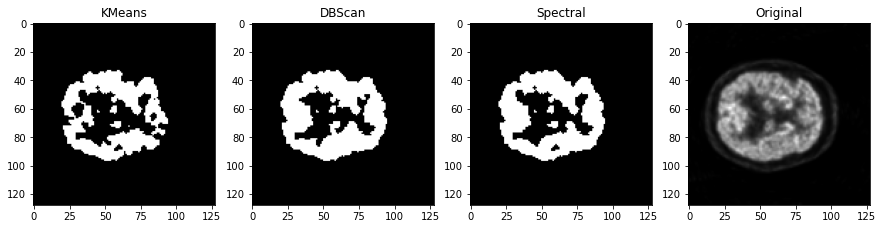

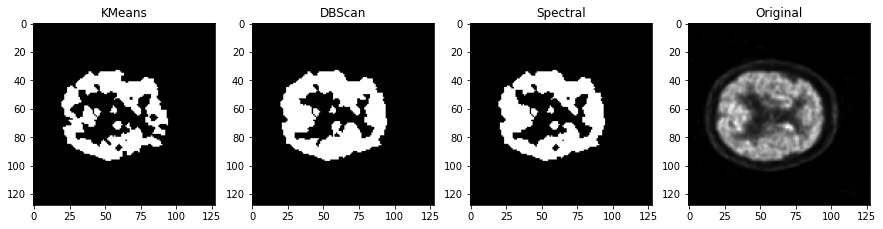

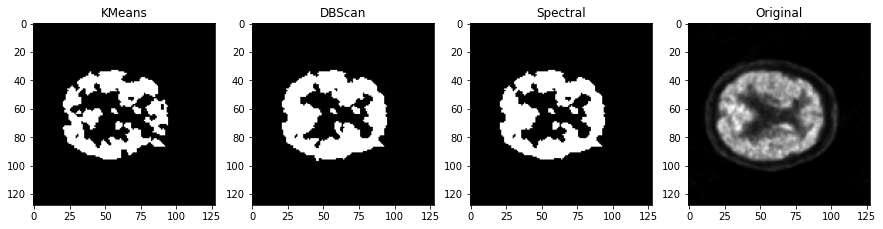

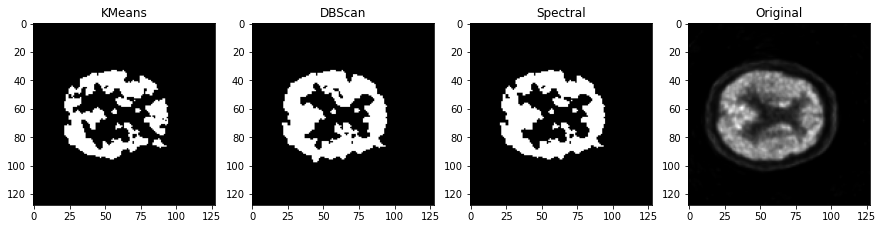

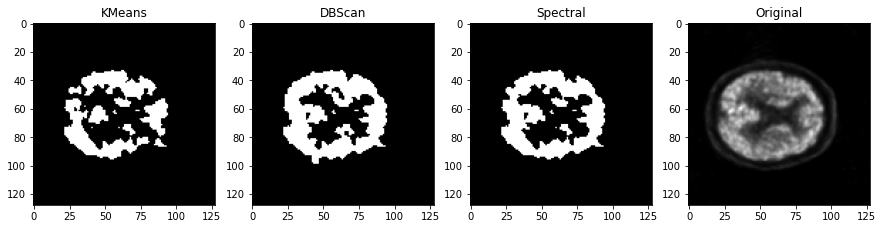

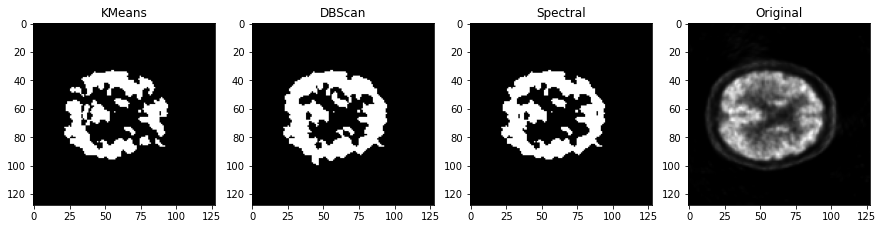

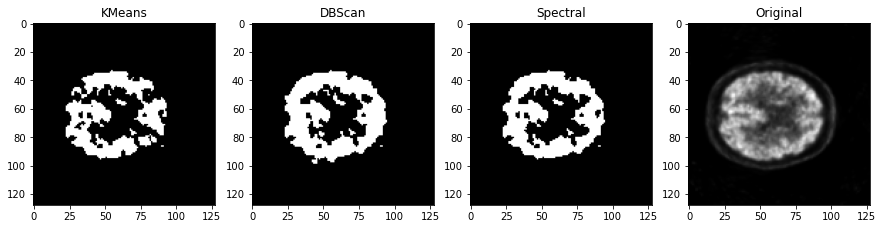

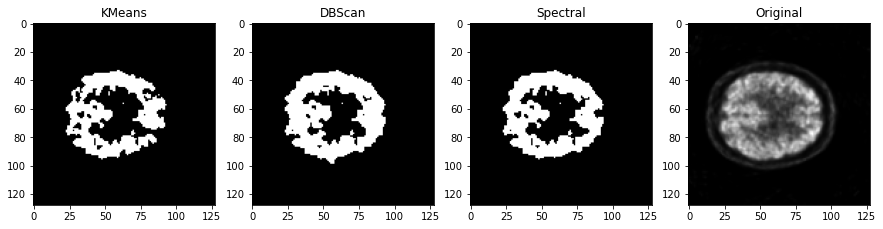

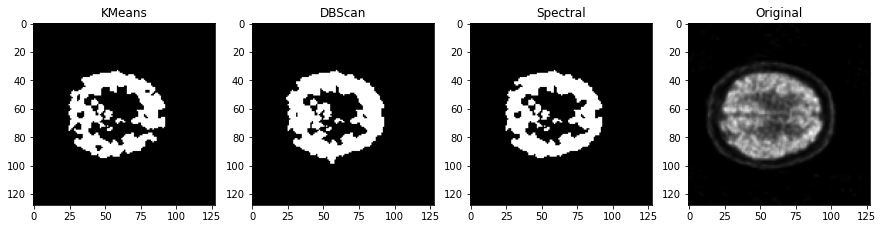

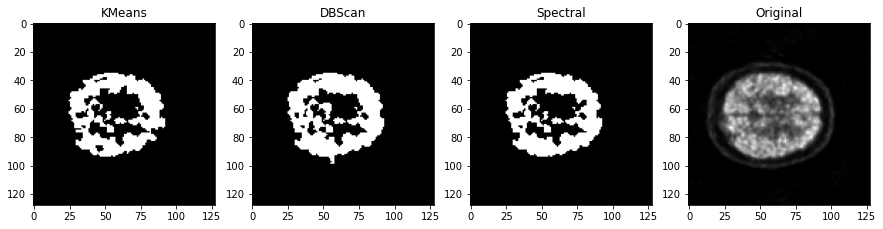

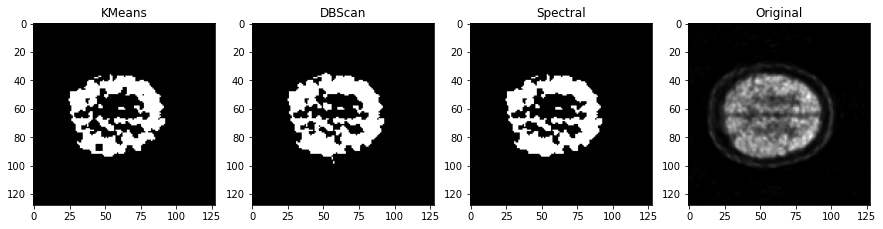

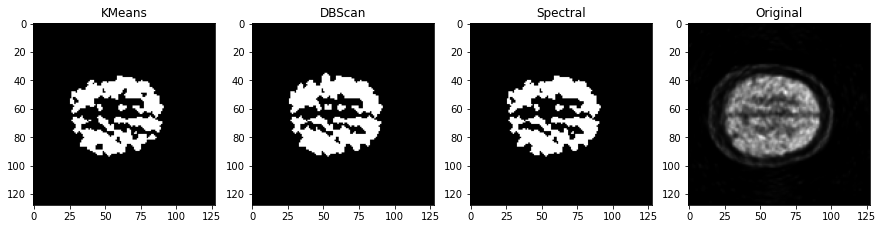

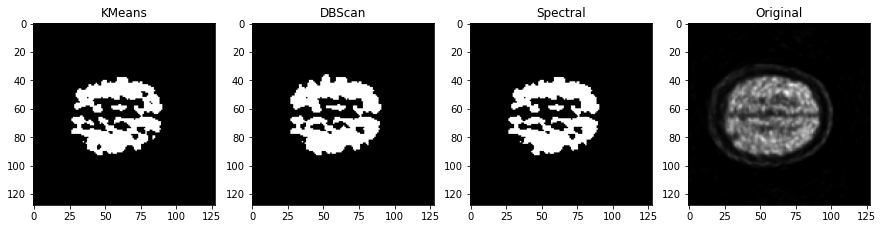

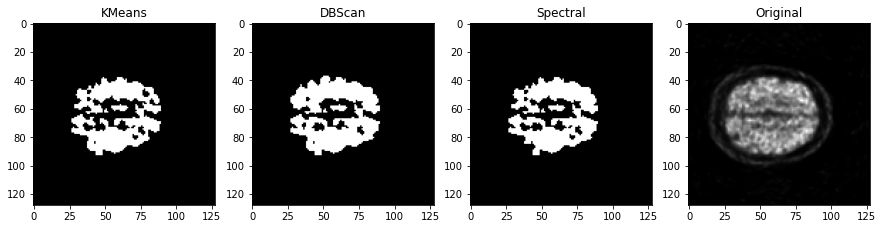

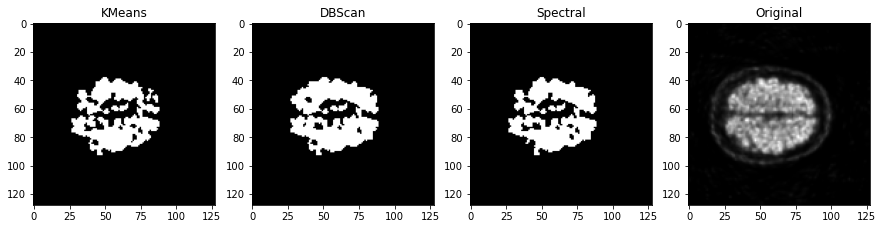

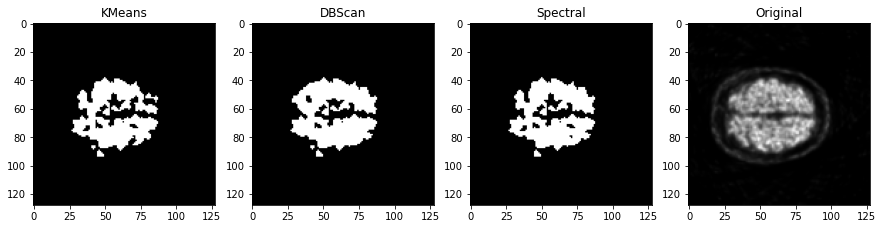

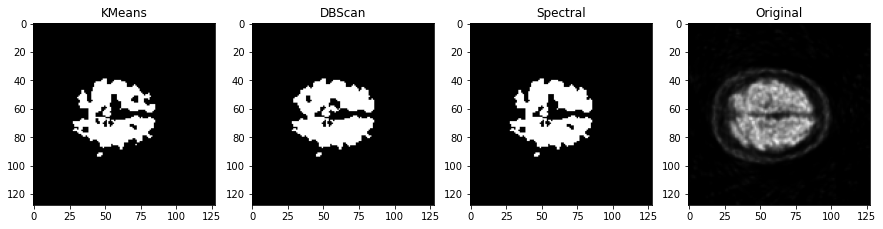

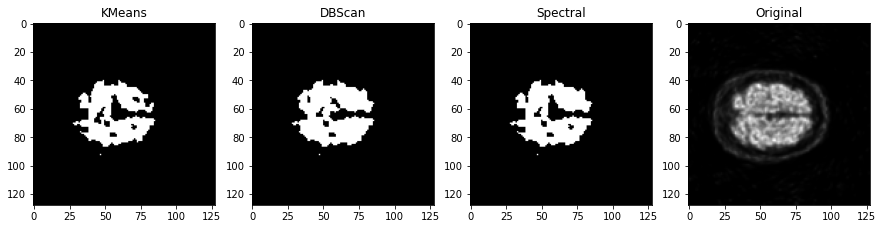

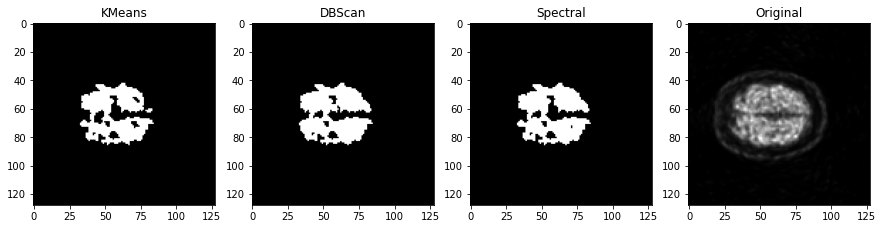

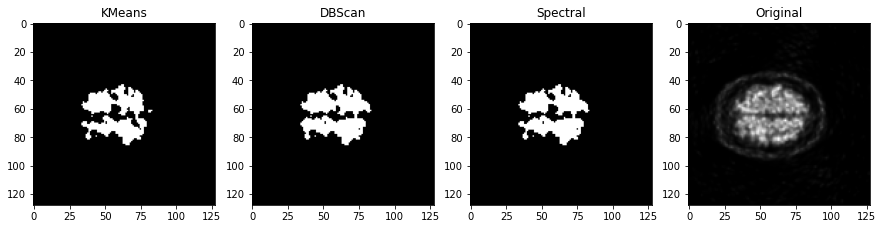

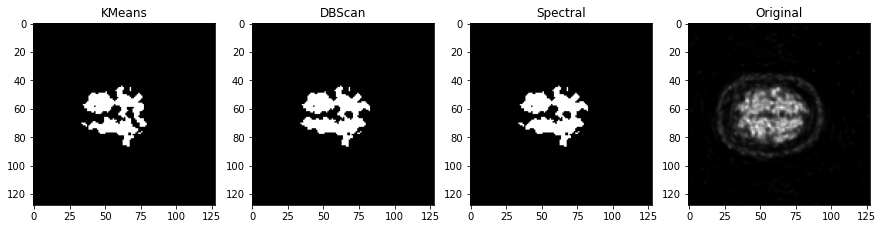

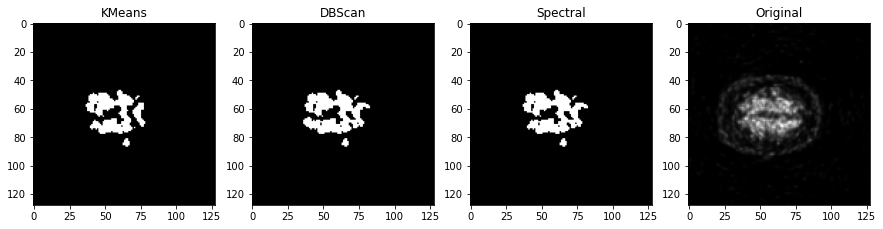

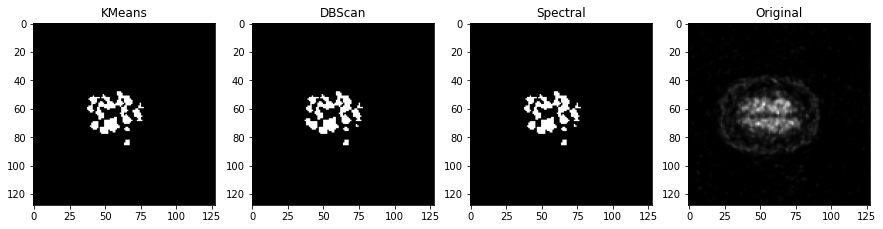

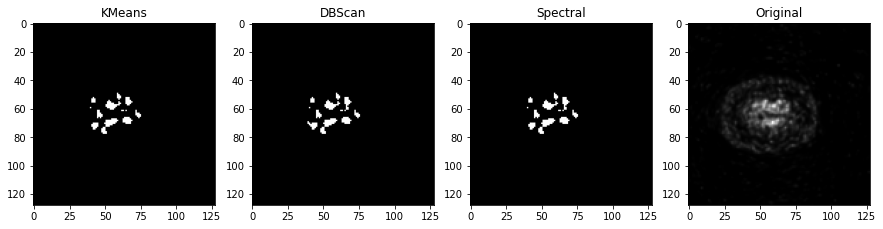

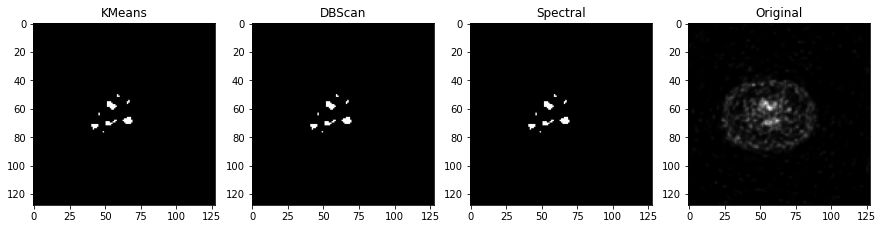

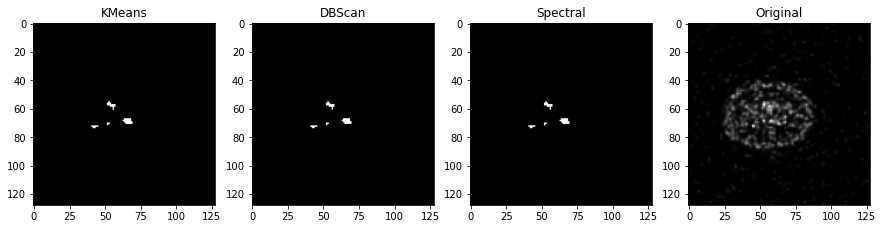

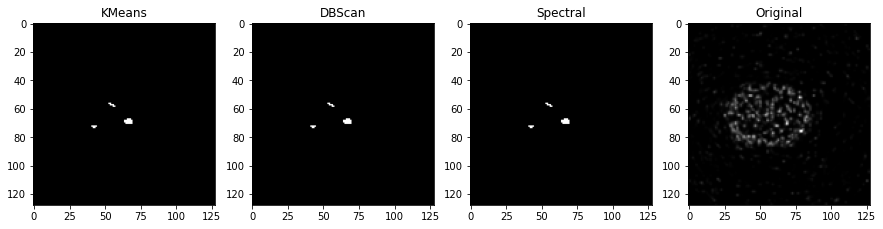

In [719]:
for i in range(63):
    plot_segment(i)